In [1]:
import random
import numpy as np
import torch
import os
import pathlib
import pickle

In [2]:
data_generation_process = "SPO_Data_Generation"
# data_generation_process = "DDR_Data_Generation"

In [3]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
grandparent_directory = os.path.dirname(parent_directory)
DataPath = os.path.dirname(grandparent_directory) + '/Data/' + data_generation_process + "/"
pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
print("grandparent_directory:", grandparent_directory)
print("DataPath:", DataPath)

grandparent_directory: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Code_MacBook
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/SPO_Data_Generation/


# Parameters

In [4]:
# import pyepo
# generate data
grid = (5,5) # grid size
num_data = 50 # number of training data
num_feat = 5 # size of feature
num_test = 1000
deg = 1.0 # polynomial degree
e = 1.0 # noise width

In [5]:
DataPath = DataPath + "data_size="+str(num_data)+"_deg="+str(deg)+"_e="+str(e)+"/"
pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)

In [6]:
def obtain_data(data_generation_process,num_data,num_test, num_feat, grid, deg, e, seed,coef_seed):
    from Data import data_generation
    data_gen = data_generation()
    if data_generation_process == "SPO_Data_Generation":
        feats, costs = data_gen.generate_Shortest_Path_Data(num_data+num_test, num_feat, grid, deg, e, seed=seed,coef_seed=coef_seed)
        # split train test data
        from sklearn.model_selection import train_test_split
        x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=num_test, random_state=42)

    if data_generation_process == "DDR_Data_Generation":
        lower = 0
        upper = 1
        p = 5
        d = 40
        alpha = 1.0
        mis = deg
        n_epsilon = 1
        W_star = data_gen.generate_truth("",lower, upper, p, d, seed,version = 0) 
        # print("W_star = ",W_star[0,:])
        x_test, z_test_ori, c_test, x_train, z_train_ori, c_train, W_star = data_gen.generate_samples("",p, d, num_test, num_data, alpha, W_star, n_epsilon, mis, thres = 10, 
                                version = 1, x_dist = 'normal', e_dist = 'normal', x_low = 0, x_up = 2, x_mean = 2, x_var = 0.25, bump = 0) 

    return x_train, x_test, c_train, c_test

In [7]:
coef_seed = 1
seed_all = np.arange(1,10)
cost_Oracle_all = {}; cost_SPO_all = {}; cost_OLS_all = {}; cost_DDR_all = {}

for seed in seed_all:
    DataPath_seed = DataPath +"Seed="+str(seed)+"/"
    pathlib.Path(DataPath_seed).mkdir(parents=True, exist_ok=True)

    # #  ****** Data generation *********
    x_train, x_test, c_train, c_test = obtain_data(data_generation_process,num_data,num_test, num_feat, grid, deg, e, seed,coef_seed=coef_seed)
    print("x_train = ",x_train[0,:])

    raw_data = {}
    raw_data["x_train"] = x_train; raw_data["x_test"] = x_test; raw_data["c_train"] = c_train; raw_data["c_test"] = c_test
    with open(DataPath_seed +'raw_data.pkl', "wb") as tf:
        pickle.dump(raw_data,tf)

    #  ****** SPO *********
    print("*** seed = ",seed,": Run SPO ========")
    from SPO_Plus import run_SPO_Shortest_Path
    SPO_runner = run_SPO_Shortest_Path()
    batch_size = 20
    num_epochs = 30
    arcs,loader_train,loader_test,cost_Oracle_all[seed],cost_SPO_all[seed] = SPO_runner.run(DataPath_seed,x_train,c_train,x_test,c_test,batch_size,num_feat,grid,num_epochs,True)
    print("Average Oracle Cost = ",np.mean(cost_Oracle_all[seed]))
    print("Average SPO Cost = ",np.mean(cost_SPO_all[seed]))
    print()

    #  ****** OLS *********
    print("*** seed = ",seed,": Run OLS ========")
    from OLS import run_OLS_Shortest_Path
    OLS_runner = run_OLS_Shortest_Path()
    cost_OLS_all[seed] = OLS_runner.run(DataPath_seed,arcs,x_train,c_train,grid,loader_test,loader_train)
    print("Average OLS Cost = ",np.mean(cost_OLS_all[seed]))
    print()

    #  ****** DDR *********
    print("*** seed = ",seed,": Run DDR ========")
    from DDR import run_DDR_Shortest_Path
    DDR_runner = run_DDR_Shortest_Path()
    mu_arr = np.arange(0.025,1.0,0.05)
    lamb_arr = np.arange(0.75,1.251,0.125)
    # mu_arr = [0.5]
    # lamb_arr = [0.1,1.0,10]
    cost_DDR_all[seed] = DDR_runner.run(DataPath_seed,lamb_arr,mu_arr,arcs,x_train, c_train, grid,loader_test,num_nodes=25)
    print()

B =  [1 0 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0 1 0 0 0 1 1 0
 0 0 0]
x_train =  [ 0.31487994  0.06061829  1.55358228 -1.06474251  0.52235859]
*** seed =  1 : Run SPO ========
Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2025-03-25
Test
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 1414.06it/s]


Test
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 2163.13it/s]


Num of cores: 2
Average Oracle Cost =  5.665825720787049
Average SPO Cost =  8.868566461284455

*** seed =  1 : Run OLS ========
Average OLS Cost =  8.654647753266138

*** seed =  1 : Run DDR ========
lambda =  0.75 , mu =  0.025 , Average DDR cost =  8.703026903819643

lambda =  0.75 , mu =  0.07500000000000001 , Average DDR cost =  8.706085666093685

lambda =  0.75 , mu =  0.12500000000000003 , Average DDR cost =  8.749279385770016

lambda =  0.75 , mu =  0.17500000000000004 , Average DDR cost =  8.707863769435601

lambda =  0.75 , mu =  0.22500000000000003 , Average DDR cost =  8.687019390645714

lambda =  0.75 , mu =  0.275 , Average DDR cost =  8.715026475865205

lambda =  0.75 , mu =  0.32500000000000007 , Average DDR cost =  8.678922917041913

lambda =  0.75 , mu =  0.37500000000000006 , Average DDR cost =  8.655999838759643

lambda =  0.75 , mu =  0.4250000000000001 , Average DDR cost =  8.68362284657381

lambda =  0.75 , mu =  0.4750000000000001 , Average DDR cost =  8.6949372

100%|██████████| 50/50 [00:00<00:00, 1152.15it/s]


Test
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 2112.70it/s]


Num of cores: 2
Average Oracle Cost =  5.664621937513352
Average SPO Cost =  8.913980299128802

*** seed =  2 : Run OLS ========
Average OLS Cost =  8.874026299010088

*** seed =  2 : Run DDR ========
lambda =  0.75 , mu =  0.025 , Average DDR cost =  8.829466209309524

lambda =  0.75 , mu =  0.07500000000000001 , Average DDR cost =  8.76267341154546

lambda =  0.75 , mu =  0.12500000000000003 , Average DDR cost =  8.794889365336044

lambda =  0.75 , mu =  0.17500000000000004 , Average DDR cost =  8.82400626971008

lambda =  0.75 , mu =  0.22500000000000003 , Average DDR cost =  8.797966972383263

lambda =  0.75 , mu =  0.275 , Average DDR cost =  8.833999403318797

lambda =  0.75 , mu =  0.32500000000000007 , Average DDR cost =  8.83173977228027

lambda =  0.75 , mu =  0.37500000000000006 , Average DDR cost =  8.850303783301555

lambda =  0.75 , mu =  0.4250000000000001 , Average DDR cost =  8.876286279171763

lambda =  0.75 , mu =  0.4750000000000001 , Average DDR cost =  8.871548005

100%|██████████| 50/50 [00:00<00:00, 1127.95it/s]


Test
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 2103.71it/s]


Num of cores: 2
Average Oracle Cost =  5.630056076645851
Average SPO Cost =  8.64286646217345

*** seed =  3 : Run OLS ========
Average OLS Cost =  8.62152981165517

*** seed =  3 : Run DDR ========
lambda =  0.75 , mu =  0.025 , Average DDR cost =  8.73197028415036

lambda =  0.75 , mu =  0.07500000000000001 , Average DDR cost =  8.756754770471453

lambda =  0.75 , mu =  0.12500000000000003 , Average DDR cost =  8.721521159311363

lambda =  0.75 , mu =  0.17500000000000004 , Average DDR cost =  8.711499777567354

lambda =  0.75 , mu =  0.22500000000000003 , Average DDR cost =  8.697562732259815

lambda =  0.75 , mu =  0.275 , Average DDR cost =  8.684554145890202

lambda =  0.75 , mu =  0.32500000000000007 , Average DDR cost =  8.669200239352328

lambda =  0.75 , mu =  0.37500000000000006 , Average DDR cost =  8.659638116830815

lambda =  0.75 , mu =  0.4250000000000001 , Average DDR cost =  8.67192448089071

lambda =  0.75 , mu =  0.4750000000000001 , Average DDR cost =  8.6545233819

100%|██████████| 50/50 [00:00<00:00, 1439.55it/s]


Test
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 2092.98it/s]


Num of cores: 2
Average Oracle Cost =  5.706039695262909
Average SPO Cost =  8.839522471940203

*** seed =  4 : Run OLS ========
Average OLS Cost =  8.659055966437242

*** seed =  4 : Run DDR ========
lambda =  0.75 , mu =  0.025 , Average DDR cost =  8.671687586327222

lambda =  0.75 , mu =  0.07500000000000001 , Average DDR cost =  8.688791066915437

lambda =  0.75 , mu =  0.12500000000000003 , Average DDR cost =  8.694403159808745

lambda =  0.75 , mu =  0.17500000000000004 , Average DDR cost =  8.688957726693857

lambda =  0.75 , mu =  0.22500000000000003 , Average DDR cost =  8.662956541264073

lambda =  0.75 , mu =  0.275 , Average DDR cost =  8.6528812943355

lambda =  0.75 , mu =  0.32500000000000007 , Average DDR cost =  8.697178389130888

lambda =  0.75 , mu =  0.37500000000000006 , Average DDR cost =  8.706034609083174

lambda =  0.75 , mu =  0.4250000000000001 , Average DDR cost =  8.670824648900743

lambda =  0.75 , mu =  0.4750000000000001 , Average DDR cost =  8.67563641

100%|██████████| 50/50 [00:00<00:00, 1205.48it/s]


Test
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 2097.13it/s]


Num of cores: 2
Average Oracle Cost =  5.697949018955231
Average SPO Cost =  8.735345614316289

*** seed =  5 : Run OLS ========
Average OLS Cost =  8.707545198216744

*** seed =  5 : Run DDR ========
lambda =  0.75 , mu =  0.025 , Average DDR cost =  8.807403690845529

lambda =  0.75 , mu =  0.07500000000000001 , Average DDR cost =  8.74600091379584

lambda =  0.75 , mu =  0.12500000000000003 , Average DDR cost =  8.724352246376453

lambda =  0.75 , mu =  0.17500000000000004 , Average DDR cost =  8.68480202614289

lambda =  0.75 , mu =  0.22500000000000003 , Average DDR cost =  8.677312365182676

lambda =  0.75 , mu =  0.275 , Average DDR cost =  8.65388809912611

lambda =  0.75 , mu =  0.32500000000000007 , Average DDR cost =  8.67114616124099

lambda =  0.75 , mu =  0.37500000000000006 , Average DDR cost =  8.683121969583445

lambda =  0.75 , mu =  0.4250000000000001 , Average DDR cost =  8.695834390281235

lambda =  0.75 , mu =  0.4750000000000001 , Average DDR cost =  8.6954759645

100%|██████████| 50/50 [00:00<00:00, 1224.31it/s]


Test
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 2106.35it/s]


Num of cores: 2
Average Oracle Cost =  5.648502691745758
Average SPO Cost =  8.731464370381552

*** seed =  6 : Run OLS ========
Average OLS Cost =  8.714543309098575

*** seed =  6 : Run DDR ========
lambda =  0.75 , mu =  0.025 , Average DDR cost =  8.747839516613633

lambda =  0.75 , mu =  0.07500000000000001 , Average DDR cost =  8.75341982111754

lambda =  0.75 , mu =  0.12500000000000003 , Average DDR cost =  8.76014186108773

lambda =  0.75 , mu =  0.17500000000000004 , Average DDR cost =  8.74813015904071

lambda =  0.75 , mu =  0.22500000000000003 , Average DDR cost =  8.736269080543222

lambda =  0.75 , mu =  0.275 , Average DDR cost =  8.738598424949247

lambda =  0.75 , mu =  0.32500000000000007 , Average DDR cost =  8.769717189074901

lambda =  0.75 , mu =  0.37500000000000006 , Average DDR cost =  8.741340133973688

lambda =  0.75 , mu =  0.4250000000000001 , Average DDR cost =  8.753458286173176

lambda =  0.75 , mu =  0.4750000000000001 , Average DDR cost =  8.770220516

100%|██████████| 50/50 [00:00<00:00, 1181.70it/s]


Test
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 2107.56it/s]


Num of cores: 2
Average Oracle Cost =  5.690151657223701
Average SPO Cost =  8.75082548400112

*** seed =  7 : Run OLS ========
Average OLS Cost =  8.750605187269969

*** seed =  7 : Run DDR ========
lambda =  0.75 , mu =  0.025 , Average DDR cost =  8.804559828220233

lambda =  0.75 , mu =  0.07500000000000001 , Average DDR cost =  8.817546819128394

lambda =  0.75 , mu =  0.12500000000000003 , Average DDR cost =  8.823319389163233

lambda =  0.75 , mu =  0.17500000000000004 , Average DDR cost =  8.779278207105534

lambda =  0.75 , mu =  0.22500000000000003 , Average DDR cost =  8.778978428383306

lambda =  0.75 , mu =  0.275 , Average DDR cost =  8.775298861311407

lambda =  0.75 , mu =  0.32500000000000007 , Average DDR cost =  8.802827339475167

lambda =  0.75 , mu =  0.37500000000000006 , Average DDR cost =  8.799734611117755

lambda =  0.75 , mu =  0.4250000000000001 , Average DDR cost =  8.80727507806442

lambda =  0.75 , mu =  0.4750000000000001 , Average DDR cost =  8.79184917

100%|██████████| 50/50 [00:00<00:00, 1122.41it/s]


Test
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 2098.24it/s]


Num of cores: 2
Average Oracle Cost =  5.59540126812458
Average SPO Cost =  8.600276346161532

*** seed =  8 : Run OLS ========
Average OLS Cost =  8.561576383497297

*** seed =  8 : Run DDR ========
lambda =  0.75 , mu =  0.025 , Average DDR cost =  8.6592264310182

lambda =  0.75 , mu =  0.07500000000000001 , Average DDR cost =  8.679780800787784

lambda =  0.75 , mu =  0.12500000000000003 , Average DDR cost =  8.68677184071071

lambda =  0.75 , mu =  0.17500000000000004 , Average DDR cost =  8.648391070952922

lambda =  0.75 , mu =  0.22500000000000003 , Average DDR cost =  8.605553231322956

lambda =  0.75 , mu =  0.275 , Average DDR cost =  8.62780374265863

lambda =  0.75 , mu =  0.32500000000000007 , Average DDR cost =  8.608218059997357

lambda =  0.75 , mu =  0.37500000000000006 , Average DDR cost =  8.614820911323935

lambda =  0.75 , mu =  0.4250000000000001 , Average DDR cost =  8.617732324851495

lambda =  0.75 , mu =  0.4750000000000001 , Average DDR cost =  8.61256326017

100%|██████████| 50/50 [00:00<00:00, 1247.04it/s]


Test
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 2093.84it/s]


Num of cores: 2
Average Oracle Cost =  5.624622785925865
Average SPO Cost =  8.707452083686542

*** seed =  9 : Run OLS ========
Average OLS Cost =  8.569627269681558

*** seed =  9 : Run DDR ========
lambda =  0.75 , mu =  0.025 , Average DDR cost =  8.610815065592018

lambda =  0.75 , mu =  0.07500000000000001 , Average DDR cost =  8.579986292490226

lambda =  0.75 , mu =  0.12500000000000003 , Average DDR cost =  8.604730532128087

lambda =  0.75 , mu =  0.17500000000000004 , Average DDR cost =  8.566733013410078

lambda =  0.75 , mu =  0.22500000000000003 , Average DDR cost =  8.522608794009429

lambda =  0.75 , mu =  0.275 , Average DDR cost =  8.510771087054746

lambda =  0.75 , mu =  0.32500000000000007 , Average DDR cost =  8.515907268657

lambda =  0.75 , mu =  0.37500000000000006 , Average DDR cost =  8.508741999365972

lambda =  0.75 , mu =  0.4250000000000001 , Average DDR cost =  8.509018523204723

lambda =  0.75 , mu =  0.4750000000000001 , Average DDR cost =  8.531334340

# Results

In [8]:
cost_OLS_avg = 0; cost_SPO_avg = 0; cost_Oracle_avg = 0; cost_DDR_avg = np.zeros((len(lamb_arr),len(mu_arr)))
for seed in seed_all:
    cost_ddr_opt = 10000
    lamb_opt = 0
    mu_opt = 0
    ddr_ols_ratio = 0

    cost_Oracle_avg = cost_Oracle_avg + np.mean(cost_Oracle_all[seed])
    cost_OLS_avg = cost_OLS_avg + np.mean(cost_OLS_all[seed])
    cost_SPO_avg = cost_SPO_avg + np.mean(cost_SPO_all[seed]) 
    lamb_index = 0
    for lamb in lamb_arr:
        mu_index = 0
        for mu in mu_arr:
            # print("Seed = ",seed,", lamb_opt = ",lamb,",mu_opt = ",mu,", Average DRR Cost = ", np.round(np.mean(cost_DDR_all[seed][lamb,mu]["cost"]),4))
            if np.mean(cost_DDR_all[seed][lamb,mu]["cost"]) < cost_ddr_opt:
                cost_ddr_opt = np.mean(cost_DDR_all[seed][lamb,mu]["cost"])
                lamb_opt = lamb
                mu_opt = mu
                ddr_ols_ratio = ((np.mean(cost_OLS_all[seed])) - cost_ddr_opt)/(np.mean(cost_OLS_all[seed]) - np.mean(cost_Oracle_all[seed]))
                ddr_spo_ratio = ((np.mean(cost_SPO_all[seed])) - cost_ddr_opt)/(np.mean(cost_SPO_all[seed]) - np.mean(cost_Oracle_all[seed]))
            cost_DDR_avg[lamb_index,mu_index] = cost_DDR_avg[lamb_index,mu_index] + np.mean(cost_DDR_all[seed][lamb,mu]["cost"])
            mu_index = mu_index + 1
        lamb_index = lamb_index + 1
    print("Seed = ",seed,", lamb_opt = ",lamb_opt,",mu_opt = ",mu_opt,", Average DRR Cost = ", np.round(cost_ddr_opt,4), \
          "DDR_OLS_ratio = ",np.round(ddr_ols_ratio,4), "DDR_SPO_ratio = ",np.round(ddr_spo_ratio,4))


Seed =  1 , lamb_opt =  0.75 ,mu_opt =  0.9750000000000002 , Average DRR Cost =  8.6469 DDR_OLS_ratio =  0.0026 DDR_SPO_ratio =  0.0692
Seed =  2 , lamb_opt =  1.0 ,mu_opt =  0.07500000000000001 , Average DRR Cost =  8.7054 DDR_OLS_ratio =  0.0525 DDR_SPO_ratio =  0.0642
Seed =  3 , lamb_opt =  1.125 ,mu_opt =  0.8750000000000002 , Average DRR Cost =  8.5995 DDR_OLS_ratio =  0.0074 DDR_SPO_ratio =  0.0144
Seed =  4 , lamb_opt =  1.125 ,mu_opt =  0.8250000000000002 , Average DRR Cost =  8.6091 DDR_OLS_ratio =  0.0169 DDR_SPO_ratio =  0.0735
Seed =  5 , lamb_opt =  1.25 ,mu_opt =  0.32500000000000007 , Average DRR Cost =  8.6426 DDR_OLS_ratio =  0.0216 DDR_SPO_ratio =  0.0306
Seed =  6 , lamb_opt =  0.75 ,mu_opt =  0.7250000000000001 , Average DRR Cost =  8.7179 DDR_OLS_ratio =  -0.0011 DDR_SPO_ratio =  0.0044
Seed =  7 , lamb_opt =  1.25 ,mu_opt =  0.9750000000000002 , Average DRR Cost =  8.7354 DDR_OLS_ratio =  0.005 DDR_SPO_ratio =  0.005
Seed =  8 , lamb_opt =  0.875 ,mu_opt =  0.975

In [29]:
(cost_OLS_avg - cost_DDR_avg[3,-3] )/(cost_OLS_avg - cost_Oracle_avg)

np.float64(0.004326643115111442)

In [25]:
cost_DDR_avg

array([[78.56599552, 78.49103956, 78.55940894, 78.35966202, 78.16622754,
        78.19282153, 78.24485734, 78.21973597, 78.28597686, 78.29808834,
        78.24289766, 78.16885513, 78.13535348, 78.18614069, 78.15400272,
        78.09545994, 78.05510235, 78.04255609, 78.06798723, 78.11757133],
       [78.63400542, 78.62502012, 78.5920511 , 78.39159369, 78.2136423 ,
        78.2278238 , 78.25314228, 78.243815  , 78.31549598, 78.29772264,
        78.23981832, 78.27187727, 78.18089719, 78.19643692, 78.17452807,
        78.12570742, 78.01272491, 78.02888278, 78.06535847, 78.1077536 ],
       [78.83156593, 78.841606  , 78.73452119, 78.63444715, 78.4233159 ,
        78.34119357, 78.3259344 , 78.30840947, 78.31073194, 78.27386005,
        78.25279396, 78.25530559, 78.23890796, 78.15771002, 78.17896103,
        78.12724751, 78.04074819, 78.01856992, 78.05023768, 78.1027808 ],
       [79.09288529, 78.92257561, 78.98992767, 78.85870459, 78.58587615,
        78.45802097, 78.41640463, 78.41296035, 7

In [22]:
cost_Oracle_avg/len(seed_all)

np.float64(5.658130094687144)

In [20]:
cost_OLS_avg/len(seed_all)

np.float64(8.679239686459198)

In [21]:
cost_DDR_avg[2,-3]/len(seed_all)

np.float64(8.668729991467679)

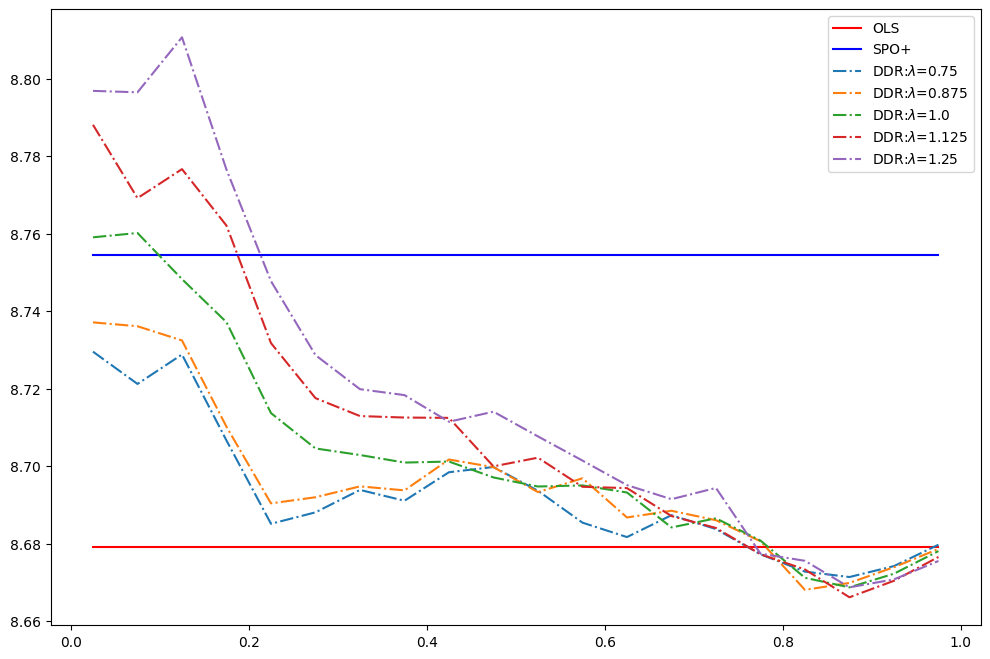

In [10]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(12, 8))
# ax.plot(mu_arr,np.ones(len(mu_arr))*cost_Oracle_avg/len(seed_all),'-',color = 'k',label="Oracle")
ax.plot(mu_arr,np.ones(len(mu_arr))*cost_OLS_avg/len(seed_all),'-',color = 'r',label="OLS")
ax.plot(mu_arr,np.ones(len(mu_arr))*cost_SPO_avg/len(seed_all),'-',color = 'b',label="SPO+")

lamb_index = 0
for lamb in lamb_arr:
    name = r"DDR:$\lambda$="+str(lamb)
    ax.plot(mu_arr,cost_DDR_avg[lamb_index,:]/len(seed_all),'-.',label=name)
    lamb_index = lamb_index + 1
ax.legend()

plt.show()

In [11]:
def cross_compare2plus(c_item, c_base, c_oracle):
    c_item = np.asarray(c_item)
    c_base = np.asarray(c_base)
    c_oracle = np.asarray(c_oracle)

    N = len(c_item)
    c_diff = c_item - c_base
    lbel = np.zeros((N,1))
    
    equals = np.sum(c_diff == 0)
    wins = np.sum(c_diff < 0)
    lose = np.sum(c_diff > 0)
    
    lbel[c_diff < 0] = 1
    lbel[c_diff > 0] = -1
    
    print(N, equals, wins, lose)
    print("base cost = ", np.mean(c_base),",item cost = ",np.mean(c_item))
    if N == equals:
        win_ratio = 0.5
    else:
        win_ratio = wins/(N - equals)
    cost_reduction = (np.mean(c_base) - np.mean(c_item) )/np.abs(np.mean(c_oracle))
    regret_reduction = (np.mean(c_base) - np.mean(c_item))/np.abs(np.mean(c_base) - np.mean(c_oracle))
    return lbel, win_ratio, cost_reduction, regret_reduction

In [12]:
seed = 3
lbel, win_ratio, cost_spo_ols, regret_spo_ols = cross_compare2plus(cost_SPO_all[seed],cost_OLS_all[seed], cost_Oracle_all[seed])

1000 288 361 351
base cost =  8.62152981165517 ,item cost =  8.64286646217345


In [13]:
def calculate_comparison(file_name,perf_eva,c_item, c_base, c_oracle,ypio):
    if ypio == 0:
#     # compares results
        lbels, h2h, mci = perf_eva.cross_compare2(c_item, c_base, c_oracle)
        store_results(file_name,lbels=lbels,h2h=h2h,mci=mci)
        print("h2h = ",h2h)
    else:
        # compares results plus
        lbels, h2h, mci, pio = perf_eva.cross_compare2plus(c_item, c_base, c_oracle)
        store_results(file_name,lbels=lbels,h2h=h2h,mci=mci,pio=pio)
        print("h2h = ",h2h," pio = ",pio)
    # return lbels, h2h, mci